# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [604]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

### 4.5. ReliefF

In [605]:
from ReliefF import ReliefF

def reliefF(x, y):
    fs = ReliefF(n_features_to_keep=10)
    fs.fit_transform(x, y)

    return fs.top_features[:10]

### 4.6. Fisher Score

In [606]:
from skfeature.function.similarity_based import fisher_score

def fisherScore(x, y):
    return fisher_score.fisher_score(x, y)

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [607]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [608]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [609]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[3, 4],
         [3, 4]]),
  array([4, 2])],
 'TEST': [array([[1, 2],
         [1, 2]]),
  array([1, 3])]}


--Train Validation Test--



{'TRAIN': [array([[3, 4]]), array([2])],
 'TEST': [array([[1, 2],
         [1, 2]]), array([3, 1])],
 'VALIDATION': [array([[3, 4]]), array([4])]}


--K Fold--



[{'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]}]

### 1.2. Métricas de exactidação

In [610]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

,Metrics
Recall,0.666667
Precision,0.555556
F1-score,0.600000


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


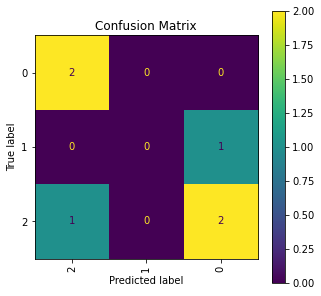

In [611]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):
    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='weighted', zero_division=0)
    ps = precision_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)

    try:
        cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
        display(cmFrame)

        cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
        _, ax = plt.subplots(figsize=(5,5))
        cmp.plot(ax=ax)
        ax.set_title("Confusion Matrix")
        ax.xaxis.set_ticklabels(labels)
        ax.xaxis.set_ticklabels(labels[::-1], rotation=90)
        plt.show()

    except:
        cmFrame = pd.DataFrame(cm).style.set_caption("Confusion Matrix")
        display(cmFrame)

cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [612]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

display(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### 2.1. k-Nearest Neighbours

In [613]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh


### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


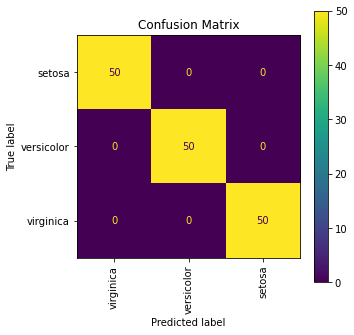

In [614]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)

### 2.1.1. TT 70-30

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,18,0,0
versicolor,0,10,0
virginica,0,0,17


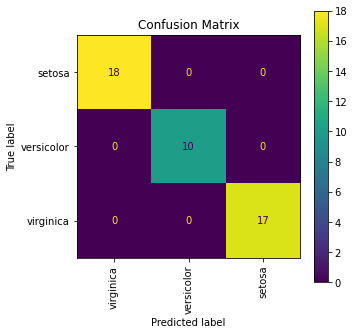

In [615]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


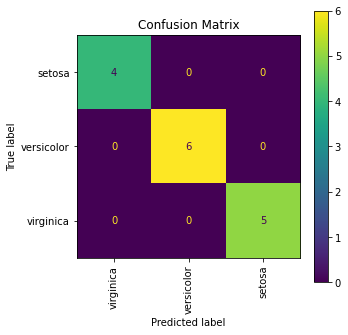

------------------- Iteração 1 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,7,0
virginica,0,0,3


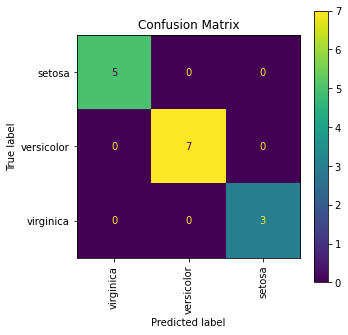

------------------- Iteração 2 -------------------


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.932867


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,6,0
virginica,0,1,5


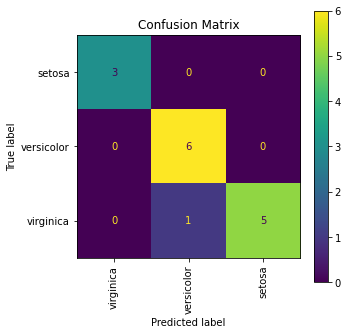

------------------- Iteração 3 -------------------


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.930370


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,2,1
virginica,0,0,4


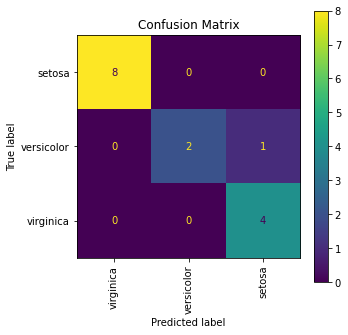

------------------- Iteração 4 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,0
virginica,0,0,5


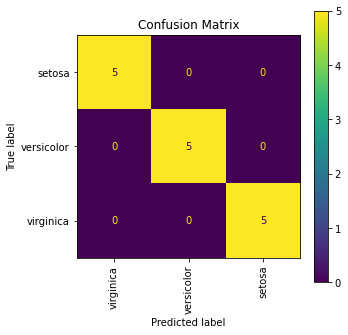

------------------- Iteração 5 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,3,0
virginica,0,0,8


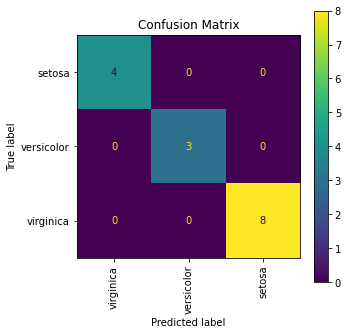

------------------- Iteração 6 -------------------


,Metrics
Recall,0.866667
Precision,0.904762
F1-score,0.864444


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,2,4


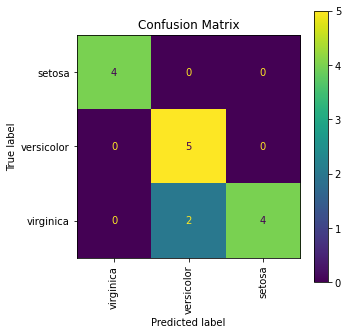

------------------- Iteração 7 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,3,0
virginica,0,0,4


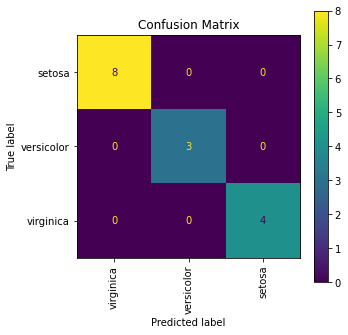

------------------- Iteração 8 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,4,0
virginica,0,0,6


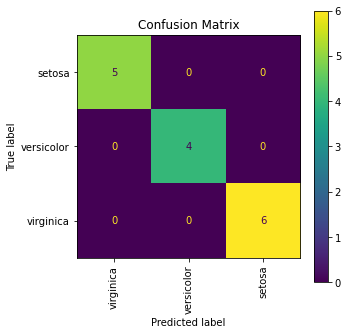

------------------- Iteração 9 -------------------


,Metrics
Recall,0.866667
Precision,0.920000
F1-score,0.873810


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,2
virginica,0,0,3


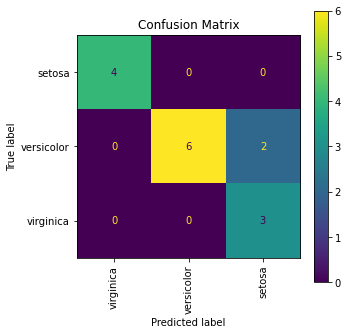

In [616]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]

        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [617]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

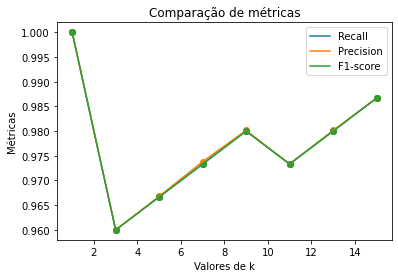

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


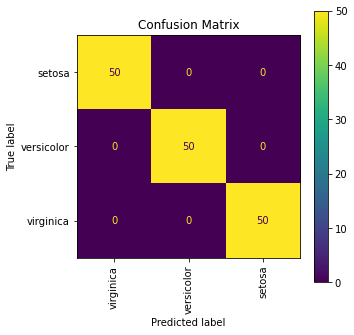

In [643]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TO_gama(data, target, iris["target_names"])

### 2.1.2. TVT 40-30-30

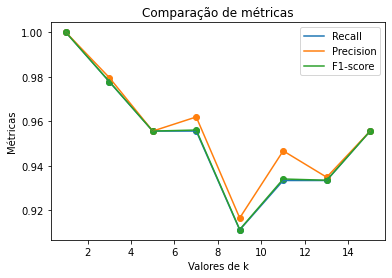

Best K: 1


,Metrics
Recall,0.911111
Precision,0.914425
F1-score,0.910161


,setosa,versicolor,virginica
setosa,14,0,0
versicolor,0,16,1
virginica,0,3,11


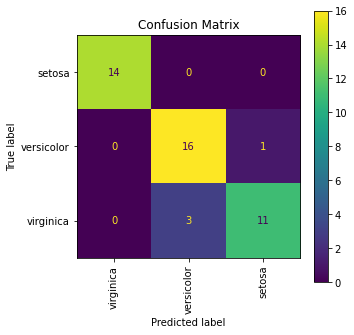

In [619]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TVT_gama(data, target, iris["target_names"])

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


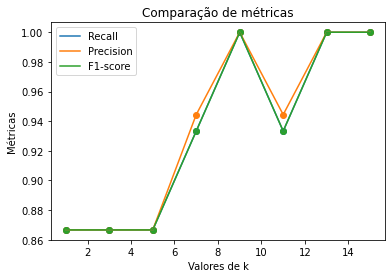

Best K: 9


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


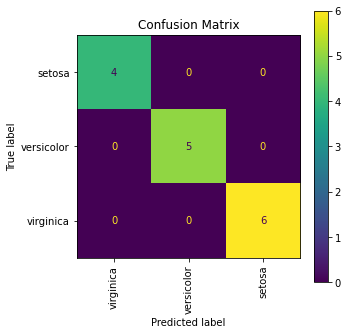

------------------- Iteração 1 -------------------


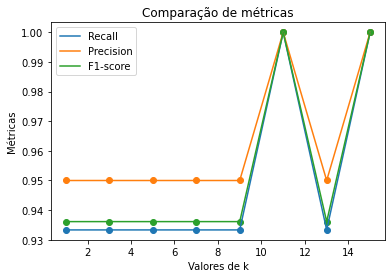

Best K: 11


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,9,0
virginica,0,0,3


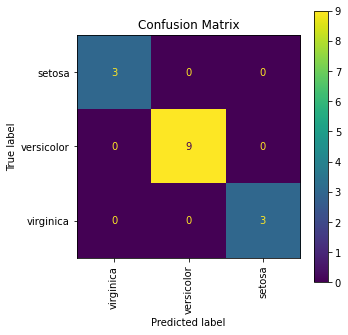

------------------- Iteração 2 -------------------


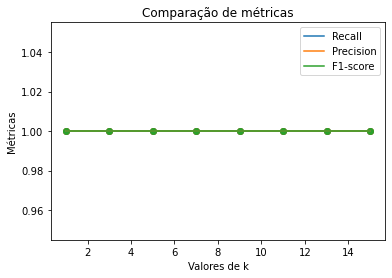

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,5,0
virginica,0,0,4


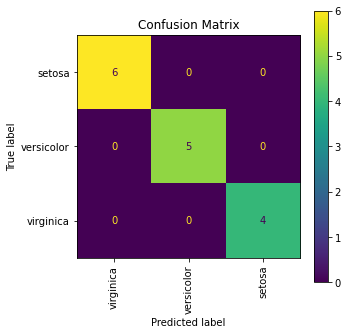

------------------- Iteração 3 -------------------


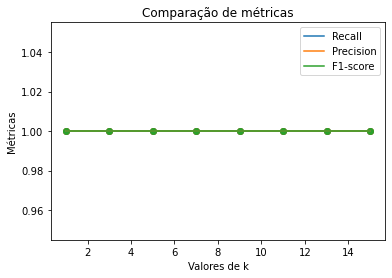

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,3,0
virginica,0,0,5


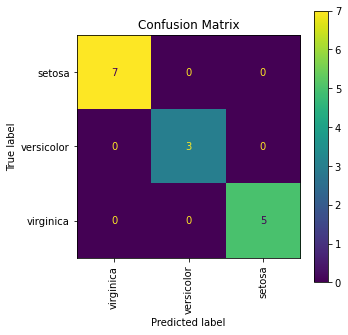

------------------- Iteração 4 -------------------


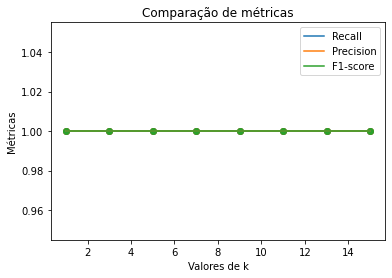

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,0
virginica,0,0,5


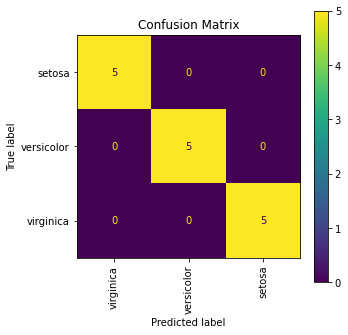

------------------- Iteração 5 -------------------


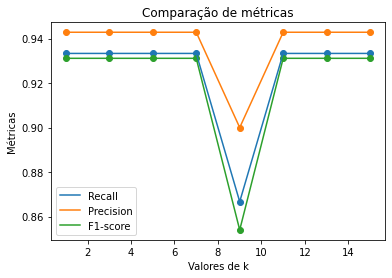

Best K: 1


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.931136


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,1,3


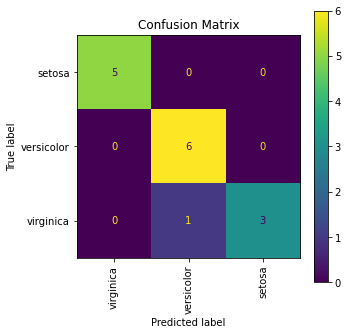

------------------- Iteração 6 -------------------


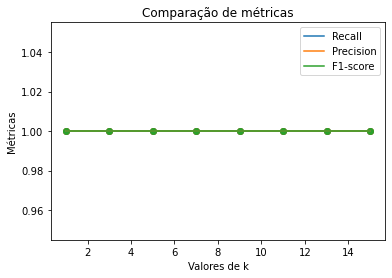

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,6,0
virginica,0,0,7


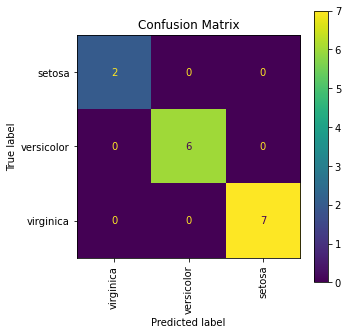

------------------- Iteração 7 -------------------


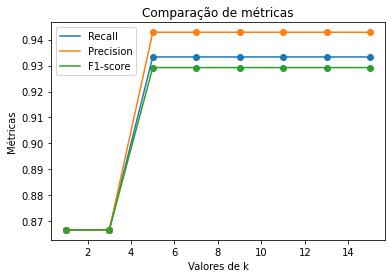

Best K: 5


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.929231


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,2,1
virginica,0,0,6


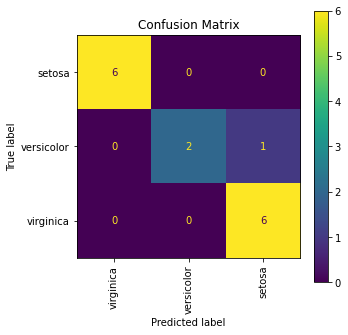

------------------- Iteração 8 -------------------


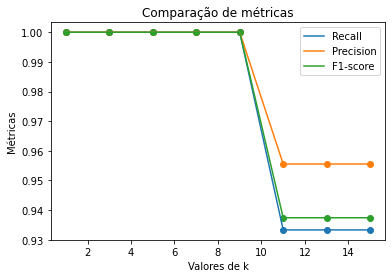

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,2,0
virginica,0,0,7


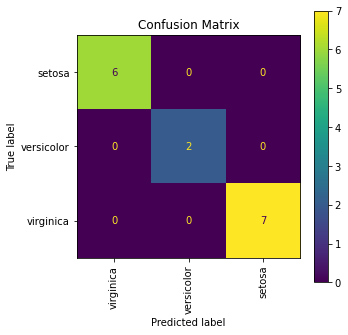

------------------- Iteração 9 -------------------


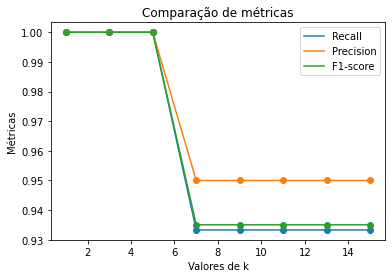

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,6,0
virginica,0,0,3


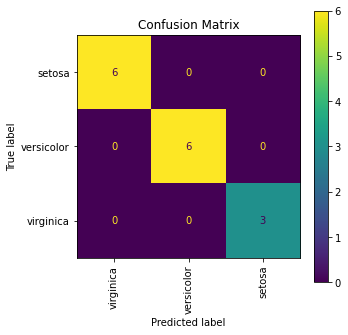

In [620]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y, labels):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

CV_gama(data, target, iris["target_names"])

### 2.2. ReliefF

In [621]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["F1-score"].append(f1)
    
    return metr


def repeatTO(x, y):
    rff = reliefF(x, y)
    f1_score = []

    for f in range(4):
        metr = {"F1-score": []}

        feat = rff[:(f+1)]
        new_metr = TO_212(x[:,feat], y, metr)

        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(new_metr)

        #------------Best k--------------------------
        print('Nr of features: ' + str(len(feat)))
        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(x[:,feat], y, best_k)
        pred = neigh.predict(x[:,feat])
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        print('F1_score: ' + str(f1))
        print('-'*50)

    label = ['Nº of features: ' + str(i+1) for i in range(len(rff))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

        
#repeatTO(data, target)

def CV_221(info, metr, feat):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0][:,feat], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0][:,feat])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["F1-score"].append(f1)

    #------------Plot F1-Score--------------------------
    plot_f1(metr)

    return metr


def repeatCV(x, y):
    rff = reliefF(x, y)

    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        f1_score = []
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        for f in range(4):

            metr = {"F1-score": []}
            feat = rff[:(f+1)]

            new_metr = CV_221(info, metr, feat)
            f1_score.append(new_metr["F1-score"])
            
            print('Nr of features: ' + str(len(feat)))
            pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
            best_k = _k[pos_k]
            print("Best K: " + str(best_k))

            neigh = K_neighbors_classifier(info['TRAIN'][0][:,feat], info['TRAIN'][1], best_k)
            pred = neigh.predict(info['TEST'][0][:,feat])
            true = info['TEST'][1]
            cm, rs, ps, f1 = metrics(true, pred)
            print('F1_score: ' + str(f1))
            print('-'*50)


        label = ['Nº of features: ' + str(i+1) for i in range(len(rff))]
        col = ['k=' + str(i) for i in _k]
        df = pd.DataFrame(f1_score, columns = col, index = label)
        display(df)
            

#repeatCV(data, target)

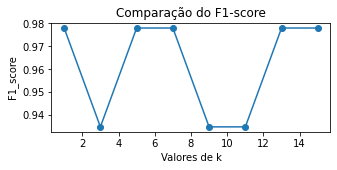

Nr of features: 1
Best K: 1
F1_score: 0.9564061669324827
--------------------------------------------------


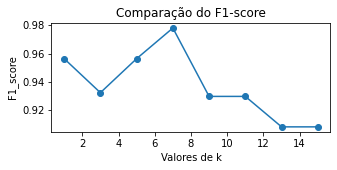

Nr of features: 2
Best K: 7
F1_score: 0.9564061669324827
--------------------------------------------------


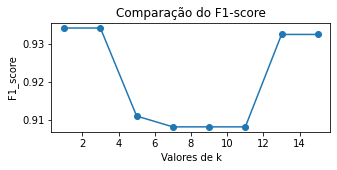

Nr of features: 3
Best K: 1
F1_score: 0.9564061669324827
--------------------------------------------------


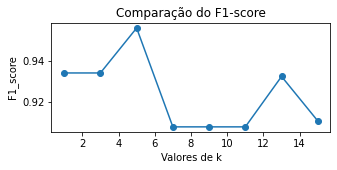

Nr of features: 4
Best K: 5
F1_score: 0.978021978021978
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.978022,0.934978,0.978022,0.978022,0.934978,0.934978,0.978022,0.978022
Nº of features: 2,0.956406,0.932392,0.956406,0.978022,0.929777,0.929777,0.908289,0.908289
Nº of features: 3,0.934066,0.934066,0.911111,0.908289,0.908289,0.908289,0.932392,0.932392
Nº of features: 4,0.934066,0.934066,0.955556,0.908289,0.908289,0.908289,0.932392,0.911111


In [622]:
def plot_f1(metr_f1):
    plt.figure(figsize=(5,2))

    plt.plot(_k, metr_f1["F1-score"])
    plt.scatter(_k, metr_f1["F1-score"])
    
    plt.title("Comparação do F1-score")
    plt.xlabel("Valores de k")
    plt.ylabel("F1_score")
    plt.show()

def bestkTVT(metr, feat, xTrain, xValidation, trainValidation, s):
    s += 'Nr of features: ' + str(len(feat)) + '\n'
    print('Nr of features: ' + str(len(feat)))
    pos_k = metr["F1-score"].index(max(metr["F1-score"]))
    best_k = _k[pos_k]
    s += "Best K: " + str(best_k) + '\n'
    print("Best K: " + str(best_k))

    newTrain0 = np.concatenate((xTrain, xValidation), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    xTest = trainValidation['TEST'][0][:,feat]
    pred = neigh.predict(xTest)
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    s += 'F1_score: ' + str(f1) + '\n' + '-'*50 + '\n'
    print('F1_score: ' + str(f1))
    print('-'*50)

    return f1, s

def repeatTVT(x, y, featselec, num = 4):

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    f1_score = []
    f1_score_elbow = []
    str_print = ''

    for f in range(num):
        metr = {"F1-score": []}
        feat = featselec[:(f+1)]
        xTrain = trainValidation['TRAIN'][0][:,feat]
        xValidation = trainValidation['VALIDATION'][0][:,feat]

        for k in _k:
            neigh = K_neighbors_classifier(xTrain, trainValidation['TRAIN'][1], k)
            pred = neigh.predict(xValidation)
            true = trainValidation['VALIDATION'][1]
            cm, rs, ps, f1 = metrics(true, pred)

            metr["F1-score"].append(f1)
        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(metr)

        #------------Best k--------------------------
        aux, str_print = bestkTVT(metr, feat, xTrain, xValidation, trainValidation, str_print)
        f1_score_elbow.append(aux)

    label = ['Nº of features: ' + str(i+1) for i in range(len(featselec))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

    return f1_score_elbow, df, str_print
        

f1_score_elbow, df223, str_print = repeatTVT(data, target, reliefF(data, target))

### 2.2.2 Elbow graph

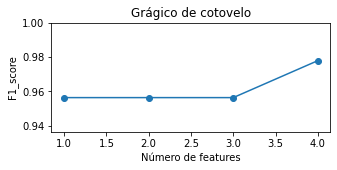

In [623]:
def elbowGraph(lista_f1, num):
    index = np.arange(1,num)

    plt.figure(figsize=(5,2))
    plt.ylim(min(lista_f1)-0.02,1)

    plt.plot(index, lista_f1)
    plt.scatter(index, lista_f1)
    
    plt.title("Grágico de cotovelo")
    plt.xlabel("Número de features")
    plt.ylabel("F1_score")
    plt.show()

elbowGraph(f1_score_elbow, 5)

### 2.2.3. Validation set results

In [624]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.978022,0.934978,0.978022,0.978022,0.934978,0.934978,0.978022,0.978022
Nº of features: 2,0.956406,0.932392,0.956406,0.978022,0.929777,0.929777,0.908289,0.908289
Nº of features: 3,0.934066,0.934066,0.911111,0.908289,0.908289,0.908289,0.932392,0.932392
Nº of features: 4,0.934066,0.934066,0.955556,0.908289,0.908289,0.908289,0.932392,0.911111


### 2.2.4. Test set results

In [625]:
print(str_print)

Nr of features: 1
Best K: 1
F1_score: 0.9564061669324827
--------------------------------------------------
Nr of features: 2
Best K: 7
F1_score: 0.9564061669324827
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9564061669324827
--------------------------------------------------
Nr of features: 4
Best K: 5
F1_score: 0.978021978021978
--------------------------------------------------



### 2.3. Fisher Score

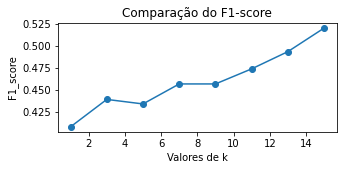

Nr of features: 1
Best K: 15
F1_score: 0.443391994478951
--------------------------------------------------


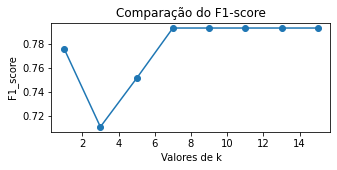

Nr of features: 2
Best K: 7
F1_score: 0.7531623931623931
--------------------------------------------------


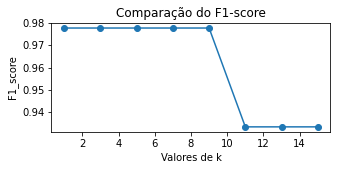

Nr of features: 3
Best K: 1
F1_score: 0.9106172839506173
--------------------------------------------------


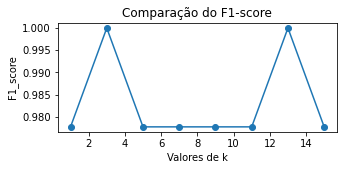

Nr of features: 4
Best K: 3
F1_score: 0.9331939605110335
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.407819,0.439192,0.434023,0.456897,0.456897,0.474164,0.493889,0.520834
Nº of features: 2,0.775926,0.711111,0.751441,0.793183,0.793183,0.793183,0.793183,0.793183
Nº of features: 3,0.977778,0.977778,0.977778,0.977778,0.977778,0.933333,0.933333,0.933333
Nº of features: 4,0.977778,1.000000,0.977778,0.977778,0.977778,0.977778,1.000000,0.977778


In [626]:
score = fisherScore(data, target)

f1_score_elbow, df223, str_print = repeatTVT(data, target, score)


### 2.3.2. Elbow Graph

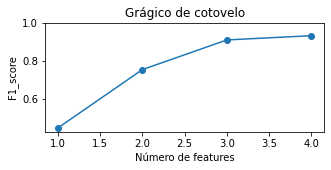

In [627]:
elbowGraph(f1_score_elbow, 5)

### 2.3.3. Validation set results

In [628]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.407819,0.439192,0.434023,0.456897,0.456897,0.474164,0.493889,0.520834
Nº of features: 2,0.775926,0.711111,0.751441,0.793183,0.793183,0.793183,0.793183,0.793183
Nº of features: 3,0.977778,0.977778,0.977778,0.977778,0.977778,0.933333,0.933333,0.933333
Nº of features: 4,0.977778,1.000000,0.977778,0.977778,0.977778,0.977778,1.000000,0.977778


### 2.3.4. Test set results

In [629]:
print(str_print)

Nr of features: 1
Best K: 15
F1_score: 0.443391994478951
--------------------------------------------------
Nr of features: 2
Best K: 7
F1_score: 0.7531623931623931
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9106172839506173
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.9331939605110335
--------------------------------------------------



### 2.4. Class imbalance

 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [630]:
irisDF = pd.DataFrame(iris.data, columns=iris["feature_names"])
irisDF["target"] = iris["target"]
setosa = irisDF[irisDF["target"] == 0]
versicolor = irisDF[irisDF["target"] == 1].sample(30)
virginica = irisDF[irisDF["target"] == 2].sample(10)
new_iris = pd.concat([setosa, versicolor, virginica], axis=0)
new_iris.groupby("target").count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,30,30,30,30
2,10,10,10,10


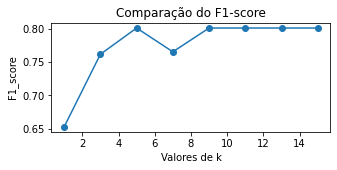

Nr of features: 1
Best K: 5
F1_score: 0.6936026936026936
--------------------------------------------------


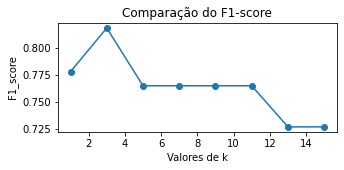

Nr of features: 2
Best K: 3
F1_score: 0.8225957049486461
--------------------------------------------------


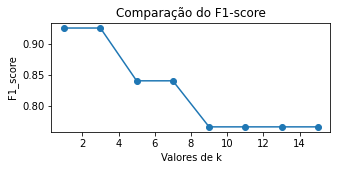

Nr of features: 3
Best K: 1
F1_score: 0.960233918128655
--------------------------------------------------


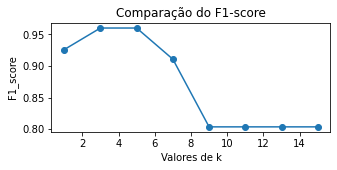

Nr of features: 4
Best K: 3
F1_score: 0.9259259259259259
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.652618,0.761905,0.801411,0.765595,0.801411,0.801411,0.801411,0.801411
Nº of features: 2,0.777778,0.818099,0.764636,0.764636,0.764636,0.764636,0.726608,0.726608
Nº of features: 3,0.925926,0.925926,0.840580,0.840580,0.766138,0.766138,0.766138,0.766138
Nº of features: 4,0.925926,0.960141,0.960141,0.910774,0.803669,0.803669,0.803669,0.803669


In [631]:
aux_data = np.array(new_iris.drop(columns=["target"]))
aux_target = np.array(new_iris["target"])

score = fisherScore(aux_data, aux_target)

newIris_elbow, df224, str_print = repeatTVT(aux_data, aux_target, score)

### 2.4.2. Elbow Graph

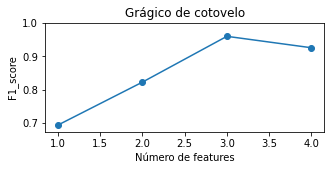

In [632]:
elbowGraph(newIris_elbow, 5)

### 2.4.3. Validation set results

In [633]:
display(df224)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.652618,0.761905,0.801411,0.765595,0.801411,0.801411,0.801411,0.801411
Nº of features: 2,0.777778,0.818099,0.764636,0.764636,0.764636,0.764636,0.726608,0.726608
Nº of features: 3,0.925926,0.925926,0.840580,0.840580,0.766138,0.766138,0.766138,0.766138
Nº of features: 4,0.925926,0.960141,0.960141,0.910774,0.803669,0.803669,0.803669,0.803669


### 2.4.4. Test set results

In [634]:
print(str_print)

Nr of features: 1
Best K: 5
F1_score: 0.6936026936026936
--------------------------------------------------
Nr of features: 2
Best K: 3
F1_score: 0.8225957049486461
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.960233918128655
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.9259259259259259
--------------------------------------------------



### 3. ReliefF for dataset of human activity

In [635]:
Acc_features = pd.read_csv("dataset/Acc_features.csv").drop(columns='Unnamed: 0')
Gyr_features = pd.read_csv("dataset/Gyr_features.csv").drop(columns=['Unnamed: 0','Label'])
Mag_features = pd.read_csv("dataset/Mag_features.csv").drop(columns=['Unnamed: 0', 'Label'])

new_data = pd.concat([Acc_features, Gyr_features, Mag_features], axis=1)
new_data.to_csv('features.csv', encoding='utf-8')
display(new_data)

new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))

,Label,Acc X Mean,Acc X Median,Acc X Std,Acc X Variance,Acc X RMS,Acc X AD,Acc X Skew,Acc X Kurtosis,Acc X IQR,...,Mag Z acc Z Corr,Mag X gyr X Corr,Mag X gyr Y Corr,Mag X gyr Z Corr,Mag Y gyr X Corr,Mag Y gyr Y Corr,Mag Y gyr Z Corr,Mag Z gyr X Corr,Mag Z gyr Y Corr,Mag Z gyr Z Corr
0,Stand,2.816928,2.81290,0.081657,0.006668,2.818100,-0.000820,0.104070,0.486731,0.084675,...,0.538935,0.288415,-0.039466,-0.261845,0.319700,-0.137996,-0.320163,-0.608719,0.247963,0.599854
1,Stand,2.864813,2.86200,0.088376,0.007810,2.866162,0.001941,-0.237104,-0.098164,0.135050,...,0.844737,-0.477185,-0.213984,0.385307,-0.190807,-0.281080,0.065046,0.434173,0.272281,-0.243218
2,Stand,2.646591,2.80950,0.347139,0.120506,2.669039,-0.011722,-0.984057,-0.323593,0.464225,...,-0.773026,-0.399344,-0.234917,0.380753,0.428215,0.272995,-0.462982,0.414267,0.233638,-0.398286
3,Stand,2.212950,2.09150,0.285796,0.081679,2.231149,-0.008253,0.830326,-0.620484,0.455650,...,-0.662408,0.547276,0.405573,-0.486648,-0.267835,-0.202777,0.193784,-0.513572,-0.399738,0.459841
4,Stand,2.058188,2.05515,0.102485,0.010503,2.060713,0.001548,0.153356,0.366587,0.133325,...,0.120578,-0.024781,-0.101842,-0.099390,-0.099077,-0.049309,-0.077035,0.184977,0.288267,0.136665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,Climb stairs (up/down) and talk -> walk and talk,-2.100210,-2.19370,0.641578,0.411623,2.195101,-0.003014,0.470363,-0.706343,0.992650,...,-0.018973,0.118220,0.258170,-0.052384,0.068988,0.407538,0.036470,0.223724,-0.114251,0.030868
14484,Climb stairs (up/down) and talk -> walk and talk,3.425963,4.08130,1.693263,2.867140,3.817886,-0.035674,-1.723238,2.626517,1.417625,...,-0.726469,-0.551289,0.193614,0.176818,-0.063941,-0.482605,-0.523068,0.652333,-0.212316,-0.115947
14485,Climb stairs (up/down) and talk -> walk and talk,2.307871,2.18690,1.030087,1.061080,2.525261,0.024127,0.010703,0.621858,0.955350,...,0.189340,-0.394748,-0.056330,0.030090,0.067419,0.096801,0.058462,0.371020,0.462721,0.366293
14486,Climb stairs (up/down) and talk -> walk and talk,1.404052,1.36710,0.719179,0.517218,1.575915,0.010513,-0.280569,0.222744,0.997815,...,0.072190,0.190854,0.447516,0.256721,0.279052,0.443746,0.507358,-0.002371,-0.630569,-0.392307


### 3.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


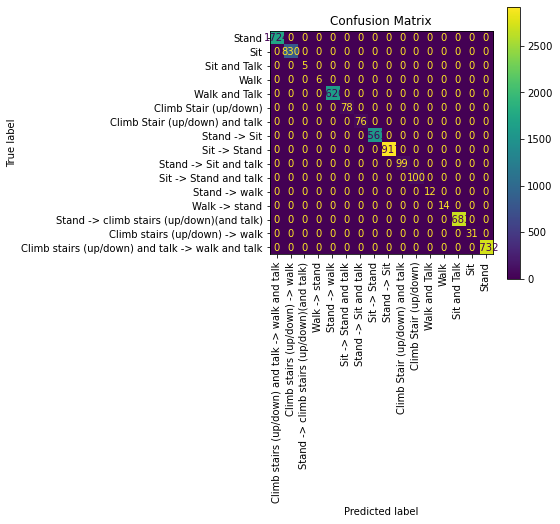

In [636]:
TO_211(feature_data, new_target, activities, 1)

### 3.1.1. TT 70-30

,Metrics
Recall,0.544744
Precision,0.540605
F1-score,0.542362


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,179,54,0,0,0,0,1,0,2,2,2,0,1,134,0,130
Sit,62,27,1,2,0,0,1,0,1,1,0,0,0,84,0,75
Sit and Talk,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,348,0,0,138,1,3,0,0,0,0,0,0
Climb Stair (up/down),3,2,0,0,0,3,2,0,11,0,0,0,0,5,0,0
Climb Stair (up/down) and talk,1,1,0,0,0,1,1,0,8,0,0,0,0,3,0,5
Stand -> Sit,1,0,0,0,110,2,1,335,3,3,3,0,0,0,0,0
Sit -> Stand,1,0,0,0,0,11,5,2,840,1,1,0,0,13,9,13
Stand -> Sit and talk,1,1,0,0,6,2,0,6,0,1,1,0,0,2,0,2


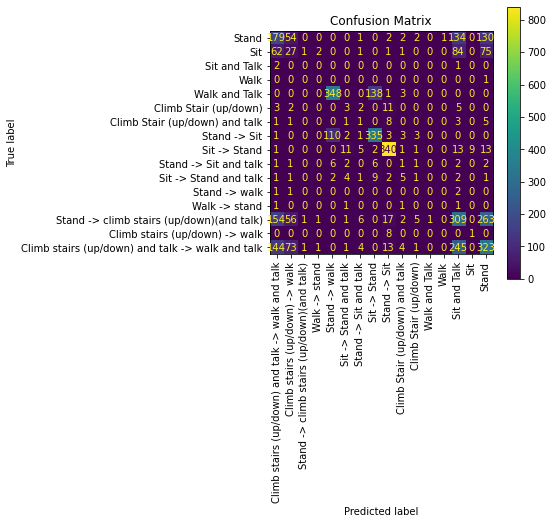

In [637]:
TT_211(feature_data, new_target, activities, 1)

### 3.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.543823
Precision,0.544561
F1-score,0.543524


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,57,27,0,0,0,0,0,0,1,0,0,1,1,51,0,42
Sit,23,10,0,0,0,0,0,0,0,1,0,0,0,28,0,16
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,118,0,0,39,1,1,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,1,0,1,0,5,0,0,0,0,2,0,1
Climb Stair (up/down) and talk,0,1,0,0,0,0,0,0,6,0,0,0,0,0,0,1
Stand -> Sit,0,0,0,0,33,0,0,121,0,1,3,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,5,6,1,255,0,0,0,0,6,1,4
Stand -> Sit and talk,1,1,0,0,0,0,0,1,0,1,1,0,0,3,0,1


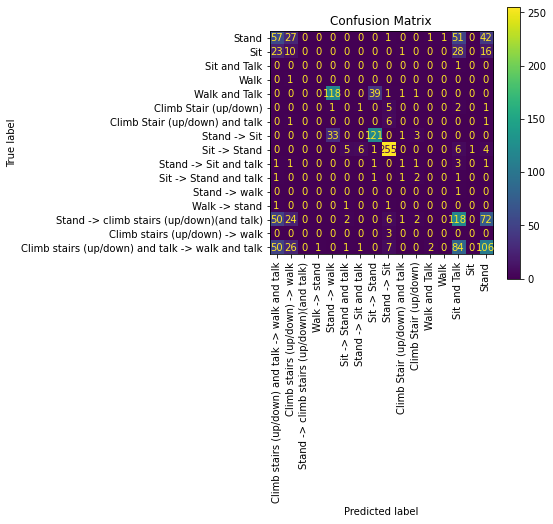

------------------- Iteração 1 -------------------


,Metrics
Recall,0.534161
Precision,0.534810
F1-score,0.533741


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,68,22,1,0,1,0,0,1,1,0,0,1,54,0,45
1,20,8,0,0,0,1,0,0,0,0,0,0,22,0,23
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,120,0,0,40,0,1,1,0,0,0,0,0
4,2,0,0,0,1,0,0,3,0,0,0,0,1,0,0
5,1,0,0,0,2,1,0,3,1,0,0,0,1,0,2
6,0,0,0,33,0,1,104,0,0,3,0,0,0,0,0
7,0,0,0,0,4,1,1,241,0,2,0,0,4,2,2
8,0,0,0,0,1,0,3,0,2,1,0,0,2,0,2
9,0,0,0,0,0,0,3,1,0,1,0,0,0,0,0


------------------- Iteração 2 -------------------


,Metrics
Recall,0.550725
Precision,0.549434
F1-score,0.549492


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,59,23,0,0,0,0,1,0,0,0,2,0,0,32,0,51
Sit,17,11,0,0,0,0,0,0,1,0,0,0,0,24,0,25
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,122,0,0,48,0,1,1,0,0,0,0,0
Climb Stair (up/down),2,1,0,0,0,0,1,0,4,1,1,0,0,1,0,0
Climb Stair (up/down) and talk,1,1,0,0,0,0,0,0,1,1,0,0,0,3,1,1
Stand -> Sit,0,0,0,0,39,0,0,116,0,0,0,0,0,0,0,0
Sit -> Stand,2,0,0,0,0,2,3,0,272,0,0,0,0,7,0,6
Stand -> Sit and talk,1,2,0,0,1,0,0,3,1,4,2,0,0,1,0,0


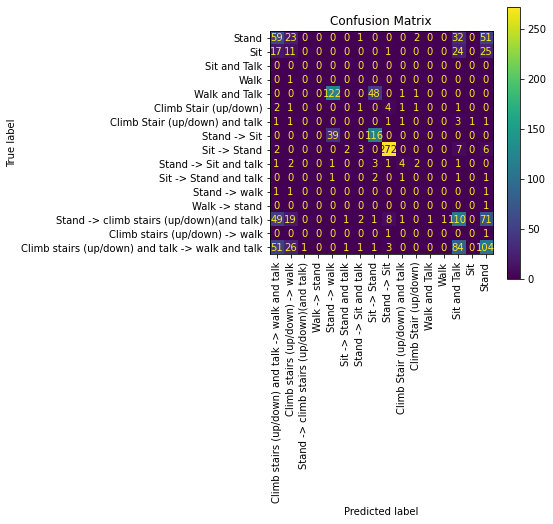

------------------- Iteração 3 -------------------


,Metrics
Recall,0.536232
Precision,0.529536
F1-score,0.532401


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,62,12,2,1,0,0,0,0,0,1,0,1,0,51,0,41
Sit,24,12,0,0,0,0,0,0,0,0,1,0,0,26,0,25
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,128,0,0,42,1,0,1,0,0,0,0,0
Climb Stair (up/down),0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,0,1,2,0,1,0,0,0,1,1
Stand -> Sit,1,0,0,0,33,0,0,108,0,2,1,0,0,0,0,0
Sit -> Stand,0,1,0,0,1,4,1,2,278,0,0,0,0,8,3,2
Stand -> Sit and talk,0,0,0,0,2,0,1,1,0,0,1,0,0,0,0,1


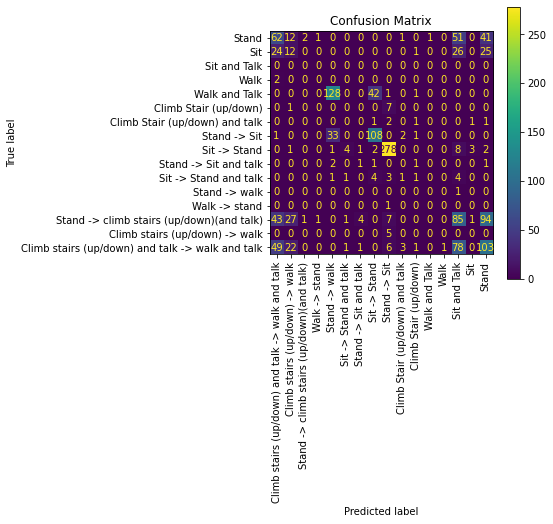

------------------- Iteração 4 -------------------


,Metrics
Recall,0.556246
Precision,0.559293
F1-score,0.556320


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,58,18,0,0,0,1,0,0,1,0,0,52,0,49
1,18,14,0,0,1,0,0,0,0,0,0,26,0,31
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,115,0,0,55,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,0,1,0,1,0,0
5,0,0,0,0,0,0,0,3,0,0,0,0,0,0
6,0,0,0,28,1,0,111,0,0,3,0,1,0,0
7,1,1,0,0,2,1,1,286,1,1,0,6,5,6
8,0,0,0,1,0,0,1,1,3,0,0,1,0,0
9,1,0,0,1,0,1,1,1,2,1,0,1,0,0


------------------- Iteração 5 -------------------


,Metrics
Recall,0.535542
Precision,0.527589
F1-score,0.530289


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,56,18,0,0,0,0,0,0,0,0,2,0,0,46,0,46
Sit,24,10,0,0,0,0,0,0,0,0,0,0,1,23,0,26
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,117,0,0,57,0,2,0,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,2,3,0,4,0,0,0,0,2,0,2
Climb Stair (up/down) and talk,1,0,0,0,0,1,0,0,6,1,1,0,0,0,0,2
Stand -> Sit,0,0,0,0,35,0,0,118,0,1,1,0,0,0,0,0
Sit -> Stand,1,1,0,0,0,2,3,1,267,0,0,0,0,1,3,3
Stand -> Sit and talk,1,0,0,0,2,0,0,1,0,0,2,0,0,2,0,2


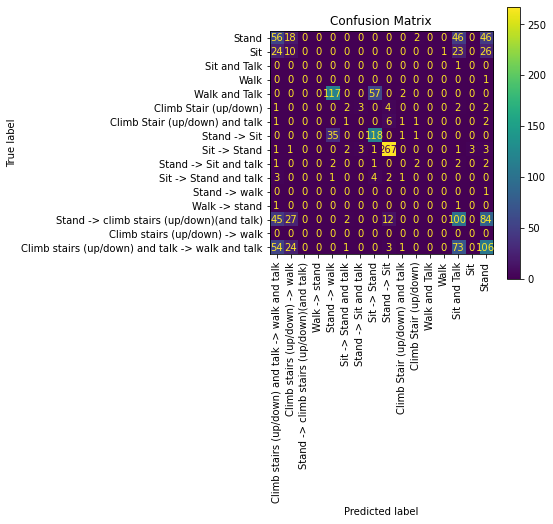

------------------- Iteração 6 -------------------


,Metrics
Recall,0.566598
Precision,0.564146
F1-score,0.564094


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,55,20,0,2,1,0,1,0,0,1,0,45,0,48
1,20,13,0,0,0,0,1,0,0,0,0,18,0,21
2,0,0,106,0,0,44,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,3,0,1,0,0,1,0,0
4,0,0,0,0,0,1,3,0,0,0,0,2,0,0
5,0,0,44,0,0,117,2,0,0,0,0,1,0,1
6,0,0,0,5,2,0,301,0,1,0,0,4,2,3
7,0,1,2,0,0,1,0,1,2,0,0,1,0,1
8,1,2,3,0,1,8,0,1,2,0,1,1,0,1
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0


------------------- Iteração 7 -------------------


,Metrics
Recall,0.542443
Precision,0.535269
F1-score,0.538185


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,67,18,0,1,0,0,0,0,0,0,1,0,0,40,0,36
Sit,20,14,0,1,0,0,0,0,1,1,0,0,0,32,0,35
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,109,0,0,39,0,1,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0
Climb Stair (up/down) and talk,0,1,0,0,0,1,1,0,2,0,0,0,0,2,0,0
Stand -> Sit,0,0,0,0,32,1,0,112,3,1,0,0,0,0,0,0
Sit -> Stand,1,0,0,0,0,2,0,0,266,1,0,0,0,4,2,3
Stand -> Sit and talk,0,0,0,0,4,0,1,4,0,0,0,0,0,0,0,0


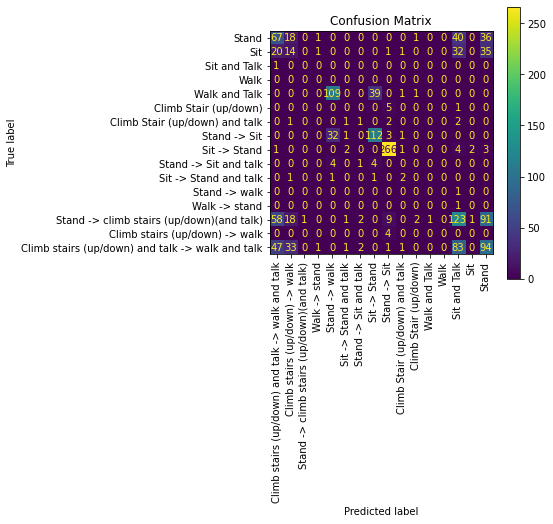

------------------- Iteração 8 -------------------


,Metrics
Recall,0.551105
Precision,0.549418
F1-score,0.549906


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,57,19,1,0,0,0,0,0,1,0,1,0,51,0,40
1,22,10,0,0,0,1,0,1,1,0,0,0,20,0,21
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,113,0,1,35,0,1,1,0,0,0,0,0
4,0,0,0,0,1,0,0,3,0,2,0,0,1,0,0
5,1,1,0,0,1,0,0,1,1,0,0,0,2,0,1
6,0,0,0,39,0,0,139,2,1,0,0,0,0,0,1
7,1,0,0,0,3,1,0,275,0,0,0,0,2,6,1
8,0,0,0,0,0,1,1,2,2,2,0,0,0,0,0
9,0,0,0,0,0,0,2,0,2,5,0,0,1,0,1


------------------- Iteração 9 -------------------


,Metrics
Recall,0.546961
Precision,0.546189
F1-score,0.545648


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,53,25,0,0,1,0,0,1,1,1,0,1,39,0,36
1,29,11,1,0,0,0,0,0,0,0,1,0,28,0,15
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,112,0,0,42,0,0,2,0,0,0,0,0
4,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2
5,0,0,0,0,1,0,0,2,0,0,0,0,2,0,1
6,0,0,0,40,0,1,123,2,0,0,0,0,1,0,0
7,3,0,0,0,3,4,0,287,1,1,0,0,4,3,5
8,1,1,0,2,0,0,4,2,1,1,0,0,1,0,2
9,1,0,0,2,1,0,3,1,1,0,0,0,2,0,0


In [638]:
CV_211(feature_data, new_target, 10, activities, 1)

### 3.1.2. Train-only

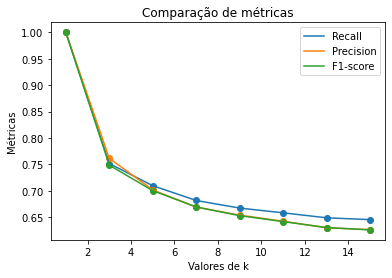

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


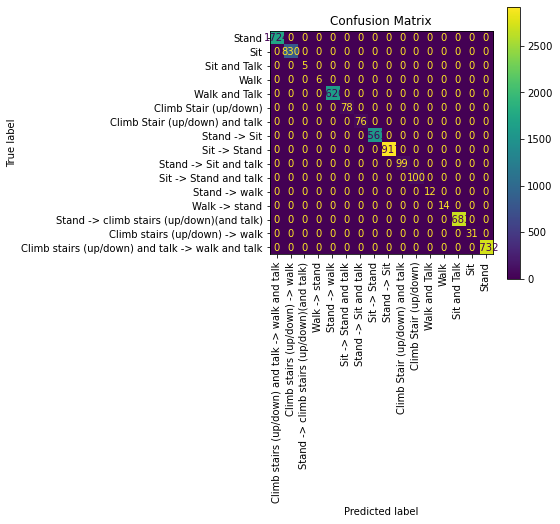

In [644]:
TO_gama(feature_data, new_target, activities)

### 3.1.2. TVT 40-30-30

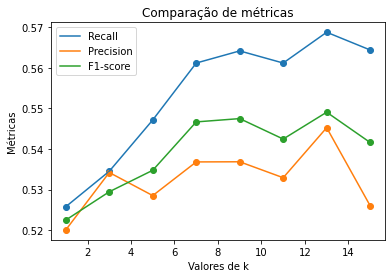

Best K: 13


,Metrics
Recall,0.564527
Precision,0.534837
F1-score,0.545927


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,230,25,0,0,0,0,0,0,0,1,1,0,0,137,0,130
Sit,102,13,0,0,0,0,0,0,0,0,0,0,0,76,0,61
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
Walk and Talk,0,0,0,0,307,0,0,167,3,1,0,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,0,0,2,14,2,0,0,0,4,0,1
Climb Stair (up/down) and talk,1,0,0,0,1,0,0,0,14,1,0,0,0,6,0,0
Stand -> Sit,0,0,0,0,133,0,0,315,7,2,0,0,0,1,0,0
Sit -> Stand,1,0,0,0,1,0,3,2,848,0,0,0,0,6,0,2
Stand -> Sit and talk,2,1,0,0,7,1,2,9,1,1,0,0,0,4,0,1


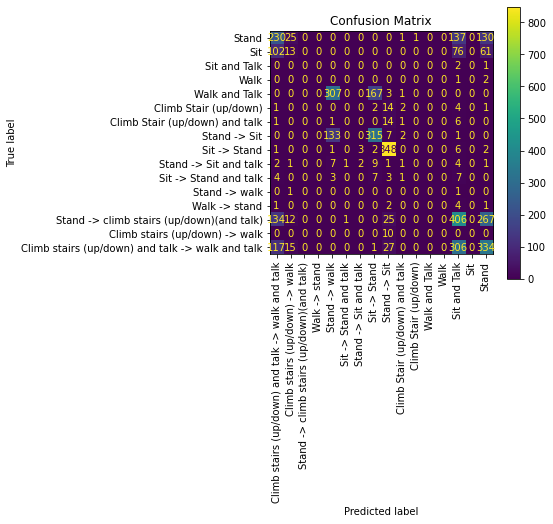

In [645]:
TVT_gama(feature_data, new_target, activities)

### 3.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


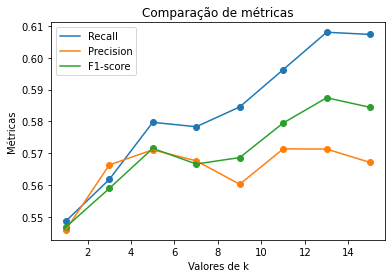

Best K: 13


,Metrics
Recall,0.608006
Precision,0.571308
F1-score,0.587430


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,89,9,0,0,0,0,0,1,0,0,44,0,42
1,36,0,0,0,0,0,0,1,0,0,25,0,28
2,0,0,113,0,0,34,0,0,0,0,0,0,0
3,2,0,0,0,0,0,5,0,0,0,0,0,0
4,1,1,0,0,0,0,5,2,0,0,1,0,0
5,0,0,31,0,0,114,3,0,0,0,0,0,0
6,1,0,0,0,0,0,306,0,0,0,2,0,3
7,0,1,1,0,0,1,0,1,0,0,3,0,0
8,1,0,0,0,0,2,0,0,0,0,3,0,0
9,0,0,0,0,0,0,0,0,0,0,1,0,1


------------------- Iteração 1 -------------------


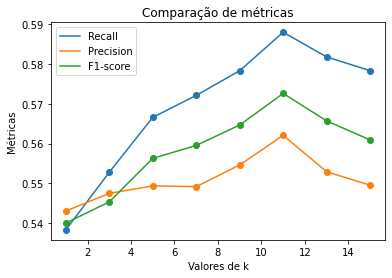

Best K: 11


,Metrics
Recall,0.587992
Precision,0.562070
F1-score,0.572609


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,73,7,0,0,0,0,0,0,0,0,0,0,56,0,36
1,28,3,0,0,0,1,0,0,0,0,0,0,16,0,21
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,120,0,0,42,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0
7,0,0,0,0,49,0,1,114,3,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,289,1,0,0,4,0,1
9,1,1,0,0,2,1,0,3,2,0,0,0,0,0,1


------------------- Iteração 2 -------------------


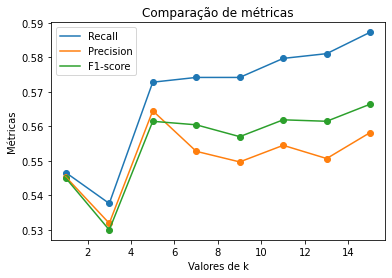

Best K: 15


,Metrics
Recall,0.587302
Precision,0.558196
F1-score,0.566423


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,80,4,0,0,0,0,0,0,0,0,0,0,54,0,40
1,34,3,0,0,0,0,0,0,0,0,0,0,23,0,20
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,114,0,0,54,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,6,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0
6,0,0,0,28,0,0,120,0,1,0,0,0,0,0,0
7,0,0,0,1,0,1,0,275,0,0,0,0,3,0,0
8,0,0,0,2,1,1,3,2,0,0,0,0,0,0,0
9,3,0,0,0,0,0,7,4,0,0,0,0,2,0,1


------------------- Iteração 3 -------------------


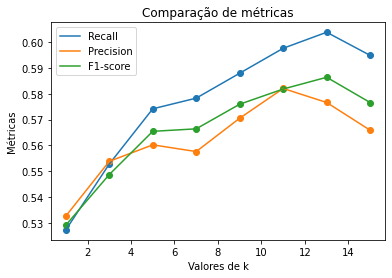

Best K: 13


,Metrics
Recall,0.603865
Precision,0.576645
F1-score,0.586411


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,87,5,0,0,0,0,0,0,0,0,43,0,49
1,21,4,0,0,0,0,1,0,0,0,22,0,22
2,0,0,118,0,0,48,1,0,0,0,1,0,0
3,0,0,0,0,0,0,5,2,0,0,3,0,3
4,0,0,0,0,0,0,5,0,0,0,2,0,0
5,0,0,27,0,0,128,2,0,0,0,0,0,0
6,2,0,2,0,0,0,285,0,0,0,2,0,0
7,0,1,1,0,1,1,1,1,1,0,2,0,1
8,0,1,2,0,0,3,1,0,0,0,2,0,0
9,0,0,0,0,0,0,0,0,0,0,1,0,0


------------------- Iteração 4 -------------------


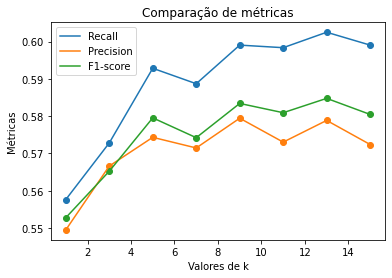

Best K: 13


,Metrics
Recall,0.602484
Precision,0.578846
F1-score,0.584756


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,80,10,0,0,0,0,0,0,0,0,0,41,0,34
1,31,9,0,0,0,0,0,0,0,0,0,20,0,15
2,0,0,101,0,0,58,1,1,1,0,0,0,0,0
3,1,0,0,0,0,0,6,1,0,0,0,1,0,0
4,1,0,0,0,0,0,12,0,0,0,0,1,0,1
5,0,0,42,1,0,109,3,0,0,0,0,0,0,1
6,1,0,4,0,0,0,308,0,0,0,0,2,0,1
7,0,0,0,0,1,2,1,2,1,0,0,2,0,1
8,0,0,2,0,0,5,1,0,0,0,0,2,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0


------------------- Iteração 5 -------------------


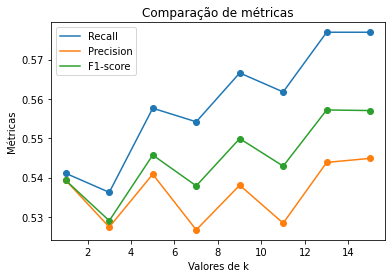

Best K: 13


,Metrics
Recall,0.576950
Precision,0.543839
F1-score,0.557187


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,82,7,0,0,0,1,0,0,0,0,0,0,0,41,35
1,29,2,0,0,0,0,0,0,0,0,0,0,0,39,29
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,116,1,0,45,2,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,3,3,0,0,0,5,0
7,0,0,0,0,36,0,0,118,3,0,0,0,0,0,0
8,0,0,0,0,0,1,0,2,280,0,0,0,0,4,1
9,1,0,0,0,1,2,0,5,0,0,0,0,0,3,2


------------------- Iteração 6 -------------------


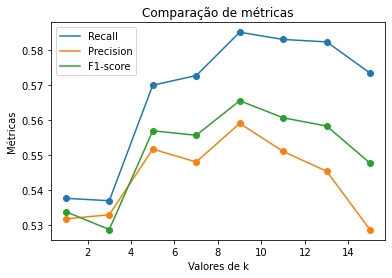

Best K: 9


,Metrics
Recall,0.585231
Precision,0.559108
F1-score,0.565591


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,77,4,0,0,0,0,0,0,0,0,0,36,0,36
1,35,8,0,0,0,0,0,0,0,0,0,28,0,26
2,0,0,114,0,0,39,1,0,1,0,0,0,0,0
3,2,0,0,1,0,0,4,0,0,0,0,1,0,0
4,1,0,0,0,0,0,6,1,0,0,0,1,0,0
5,0,0,40,0,0,105,2,1,0,0,0,0,0,0
6,0,0,0,0,0,0,278,0,1,0,0,2,0,0
7,2,0,1,0,0,4,1,0,0,0,0,4,0,1
8,0,0,3,1,1,2,2,0,0,0,0,2,0,1
9,1,0,0,0,0,0,1,0,0,0,0,0,0,0


------------------- Iteração 7 -------------------


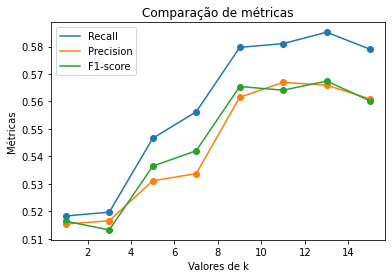

Best K: 13


,Metrics
Recall,0.585231
Precision,0.565935
F1-score,0.567438


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,72,3,0,0,0,0,0,0,0,0,0,0,54,0,39
1,42,4,0,0,0,0,0,0,0,0,0,0,20,0,23
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,109,0,0,56,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,6,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0
6,0,0,0,30,0,0,130,4,1,0,0,0,0,0,0
7,1,0,0,1,0,0,0,261,0,0,0,0,2,0,1
8,0,1,0,2,0,1,3,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,3,2,0,1,0,0,0,0,2


------------------- Iteração 8 -------------------


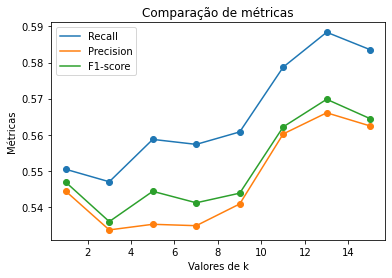

Best K: 13


,Metrics
Recall,0.588398
Precision,0.566077
F1-score,0.569816


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,82,6,0,0,0,0,0,0,0,0,0,56,0,43
1,25,5,0,0,0,0,0,0,0,0,0,32,0,27
2,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,0,0,0,110,0,0,56,2,0,0,0,0,0,0
4,0,0,0,0,1,0,0,3,0,0,0,2,0,0
5,0,0,0,1,0,0,0,2,0,1,0,3,0,1
6,0,0,0,31,0,0,117,2,0,0,0,1,0,0
7,1,0,0,0,0,0,0,286,0,0,0,2,0,1
8,1,0,0,3,2,0,2,0,0,0,0,1,0,1
9,0,0,0,0,0,0,5,1,1,1,0,3,0,0


------------------- Iteração 9 -------------------


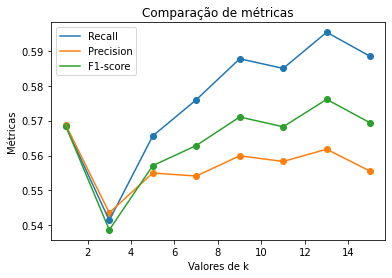

Best K: 13


,Metrics
Recall,0.595304
Precision,0.561805
F1-score,0.576084


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,70,4,0,0,0,0,0,0,1,0,0,0,49,0,42
1,32,1,0,0,0,0,0,0,1,0,0,0,25,0,13
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,112,0,0,48,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,7,0,0,0,0,1,0,1
5,1,0,0,0,0,0,0,2,0,0,0,0,1,0,1
6,0,0,0,46,0,0,115,1,0,0,0,0,0,0,0
7,4,0,0,0,0,0,0,291,0,0,0,0,2,0,1
8,0,1,0,1,1,0,2,1,1,0,0,0,1,0,0
9,1,1,0,0,0,0,3,2,1,0,0,0,0,0,0


In [646]:
CV_gama(feature_data, new_target, activities)

### 3.2. ReliefF

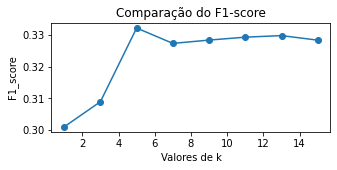

Nr of features: 1
Best K: 5
F1_score: 0.3443424534559518
--------------------------------------------------


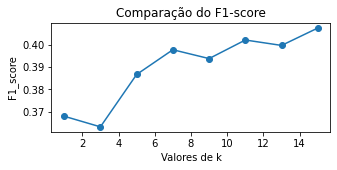

Nr of features: 2
Best K: 15
F1_score: 0.409900281712768
--------------------------------------------------


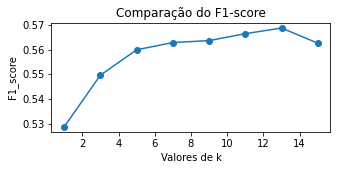

Nr of features: 3
Best K: 13
F1_score: 0.5722625092712158
--------------------------------------------------


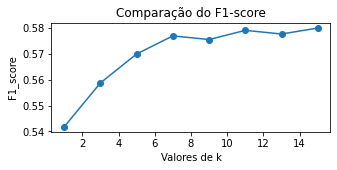

Nr of features: 4
Best K: 15
F1_score: 0.5879314674452427
--------------------------------------------------


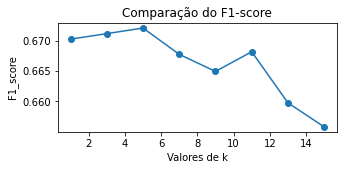

Nr of features: 5
Best K: 5
F1_score: 0.6930950620329607
--------------------------------------------------


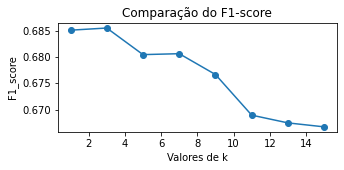

Nr of features: 6
Best K: 3
F1_score: 0.7059336748186347
--------------------------------------------------


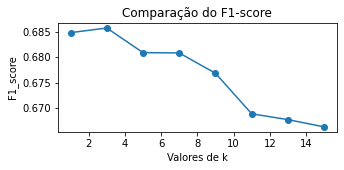

Nr of features: 7
Best K: 3
F1_score: 0.7064171458764514
--------------------------------------------------


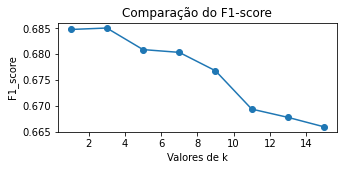

Nr of features: 8
Best K: 3
F1_score: 0.7063805055468604
--------------------------------------------------


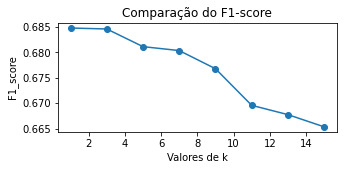

Nr of features: 9
Best K: 1
F1_score: 0.7202212634952337
--------------------------------------------------


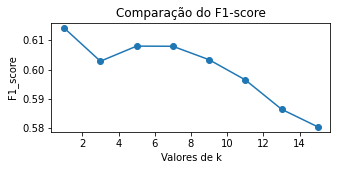

Nr of features: 10
Best K: 1
F1_score: 0.6466951276301427
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.300985,0.308955,0.332325,0.327450,0.328499,0.329428,0.329921,0.328475
Nº of features: 2,0.368032,0.363283,0.386675,0.397726,0.393773,0.402072,0.399654,0.407425
Nº of features: 3,0.528772,0.549642,0.559911,0.562845,0.563621,0.566420,0.568710,0.562590
Nº of features: 4,0.541767,0.558794,0.570024,0.577040,0.575623,0.579187,0.577764,0.580087
Nº of features: 5,0.670232,0.671136,0.672058,0.667739,0.664931,0.668164,0.659780,0.655839
Nº of features: 6,0.685071,0.685480,0.680428,0.680604,0.676644,0.668927,0.667456,0.666704
Nº of features: 7,0.684836,0.685743,0.680900,0.680832,0.676834,0.668851,0.667705,0.666281
Nº of features: 8,0.684800,0.685082,0.680900,0.680362,0.676795,0.669365,0.667760,0.665919
Nº of features: 9,0.684800,0.684612,0.681137,0.680362,0.676795,0.669589,0.667760,0.665355
Nº of features: 10,0.614215,0.602887,0.608039,0.607987,0.603398,0.596506,0.586490,0.580481


In [ ]:
newActivity_elbow, df3, str_print = repeatTVT(feature_data,new_target, reliefF(feature_data, new_target), 10)

### 3.2. Elbow Graph

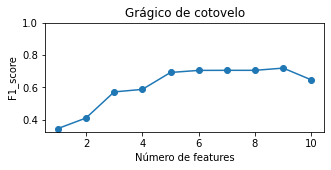

In [ ]:
elbowGraph(newActivity_elbow, 11)

### 3.3. Validation set results

In [ ]:
display(df3)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.300985,0.308955,0.332325,0.327450,0.328499,0.329428,0.329921,0.328475
Nº of features: 2,0.368032,0.363283,0.386675,0.397726,0.393773,0.402072,0.399654,0.407425
Nº of features: 3,0.528772,0.549642,0.559911,0.562845,0.563621,0.566420,0.568710,0.562590
Nº of features: 4,0.541767,0.558794,0.570024,0.577040,0.575623,0.579187,0.577764,0.580087
Nº of features: 5,0.670232,0.671136,0.672058,0.667739,0.664931,0.668164,0.659780,0.655839
Nº of features: 6,0.685071,0.685480,0.680428,0.680604,0.676644,0.668927,0.667456,0.666704
Nº of features: 7,0.684836,0.685743,0.680900,0.680832,0.676834,0.668851,0.667705,0.666281
Nº of features: 8,0.684800,0.685082,0.680900,0.680362,0.676795,0.669365,0.667760,0.665919
Nº of features: 9,0.684800,0.684612,0.681137,0.680362,0.676795,0.669589,0.667760,0.665355
Nº of features: 10,0.614215,0.602887,0.608039,0.607987,0.603398,0.596506,0.586490,0.580481


### 3.4. Test set results

In [ ]:
print(str_print)

Nr of features: 1
Best K: 5
F1_score: 0.3443424534559518
--------------------------------------------------
Nr of features: 2
Best K: 15
F1_score: 0.409900281712768
--------------------------------------------------
Nr of features: 3
Best K: 13
F1_score: 0.5722625092712158
--------------------------------------------------
Nr of features: 4
Best K: 15
F1_score: 0.5879314674452427
--------------------------------------------------
Nr of features: 5
Best K: 5
F1_score: 0.6930950620329607
--------------------------------------------------
Nr of features: 6
Best K: 3
F1_score: 0.7059336748186347
--------------------------------------------------
Nr of features: 7
Best K: 3
F1_score: 0.7064171458764514
--------------------------------------------------
Nr of features: 8
Best K: 3
F1_score: 0.7063805055468604
--------------------------------------------------
Nr of features: 9
Best K: 1
F1_score: 0.7202212634952337
--------------------------------------------------
Nr of features: 10
Best K:

In [ ]:
from sklearn.neural_network import MLPClassifier
# invscaling no 4.2

for i in np.arange(5, 100, 5)
    clf = MLPClassifier(activation='logistic', learning_rate='constant', hidden_layer_sizes=i)
    

clf.fit(dataTVT["TRAIN"], y)

SyntaxError: invalid syntax (1424055006.py, line 4)